In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("../data/crime.csv", parse_dates=True, encoding="utf-8", 
                 index_col=["object_id", "date"])
level_values = df.index.get_level_values

In [3]:
df_agg = df.groupby([level_values(0)] + [pd.Grouper(freq='W', closed='left', level=-1)]).agg(
    events =  ("cassualties", "count"),
    cassualties = ("cassualties", "sum"),
    lat = ("lat", "first"),
    lon = ("lon", "first"),
    postal_code = ("postal_code", "first"),
    mun_name = ("mun_name", "first"),
    neighborhood_name = ("neighborhood_name", "first"),
    neighborhood_type = ("neighborhood_type", "first")
)

In [12]:
df_agg.sort_index(level=['object_id','date'], inplace=True, ascending=[True, True])

In [21]:
df_agg = df_agg.loc[df_agg.index.get_level_values(0) != 0 ].copy()   

### Re-index semanas.

In [22]:
f = lambda x: np.where(df_agg.index.levels[1] == x)[0][0]
df_agg["week_id"] = list(map(f, df_agg.index.get_level_values(1)))

In [23]:
df_agg["object_id"] = df_agg.index.get_level_values(0)
df_agg["week_date"] = df_agg.index.get_level_values(1)

In [24]:
df_agg.set_index(["week_id", "object_id", "week_date"], inplace=True)

In [25]:
idx = pd.IndexSlice

### Get same week tuples

In [26]:
from itertools import combinations

In [27]:
network = set([])
for i in df_agg.index.levels[0]:
  network.update(list(combinations(df_agg.loc[idx[i, :], :].index.get_level_values(1).tolist(),2)))

### Display the network

In [28]:
network = pd.DataFrame(np.array([[t[0], t[1]] for t in network]), 
                                columns = ["source", "target"])

In [29]:
map_df = pd.read_csv("../data/map_df_all.csv")

In [30]:
nodeData = map_df[["object_id", "mun_name", "neighborhood_name", "neighborhood_type", 
                   "area", "x_centroid", "y_centroid", "with_event"]].set_index("object_id").to_dict('index')

In [31]:
import networkx as nx

In [32]:
G = nx.from_pandas_edgelist(network)
G.add_nodes_from(map_df.object_id)
nx.set_node_attributes(G, nodeData)

In [34]:
y = nx.get_node_attributes(G, "y_centroid")
x = nx.get_node_attributes(G, "x_centroid")     
pos = {key:[x[key],y[key]] for key in y.keys()}

/home/dianae/Workspace/crimenNL/vcrime/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


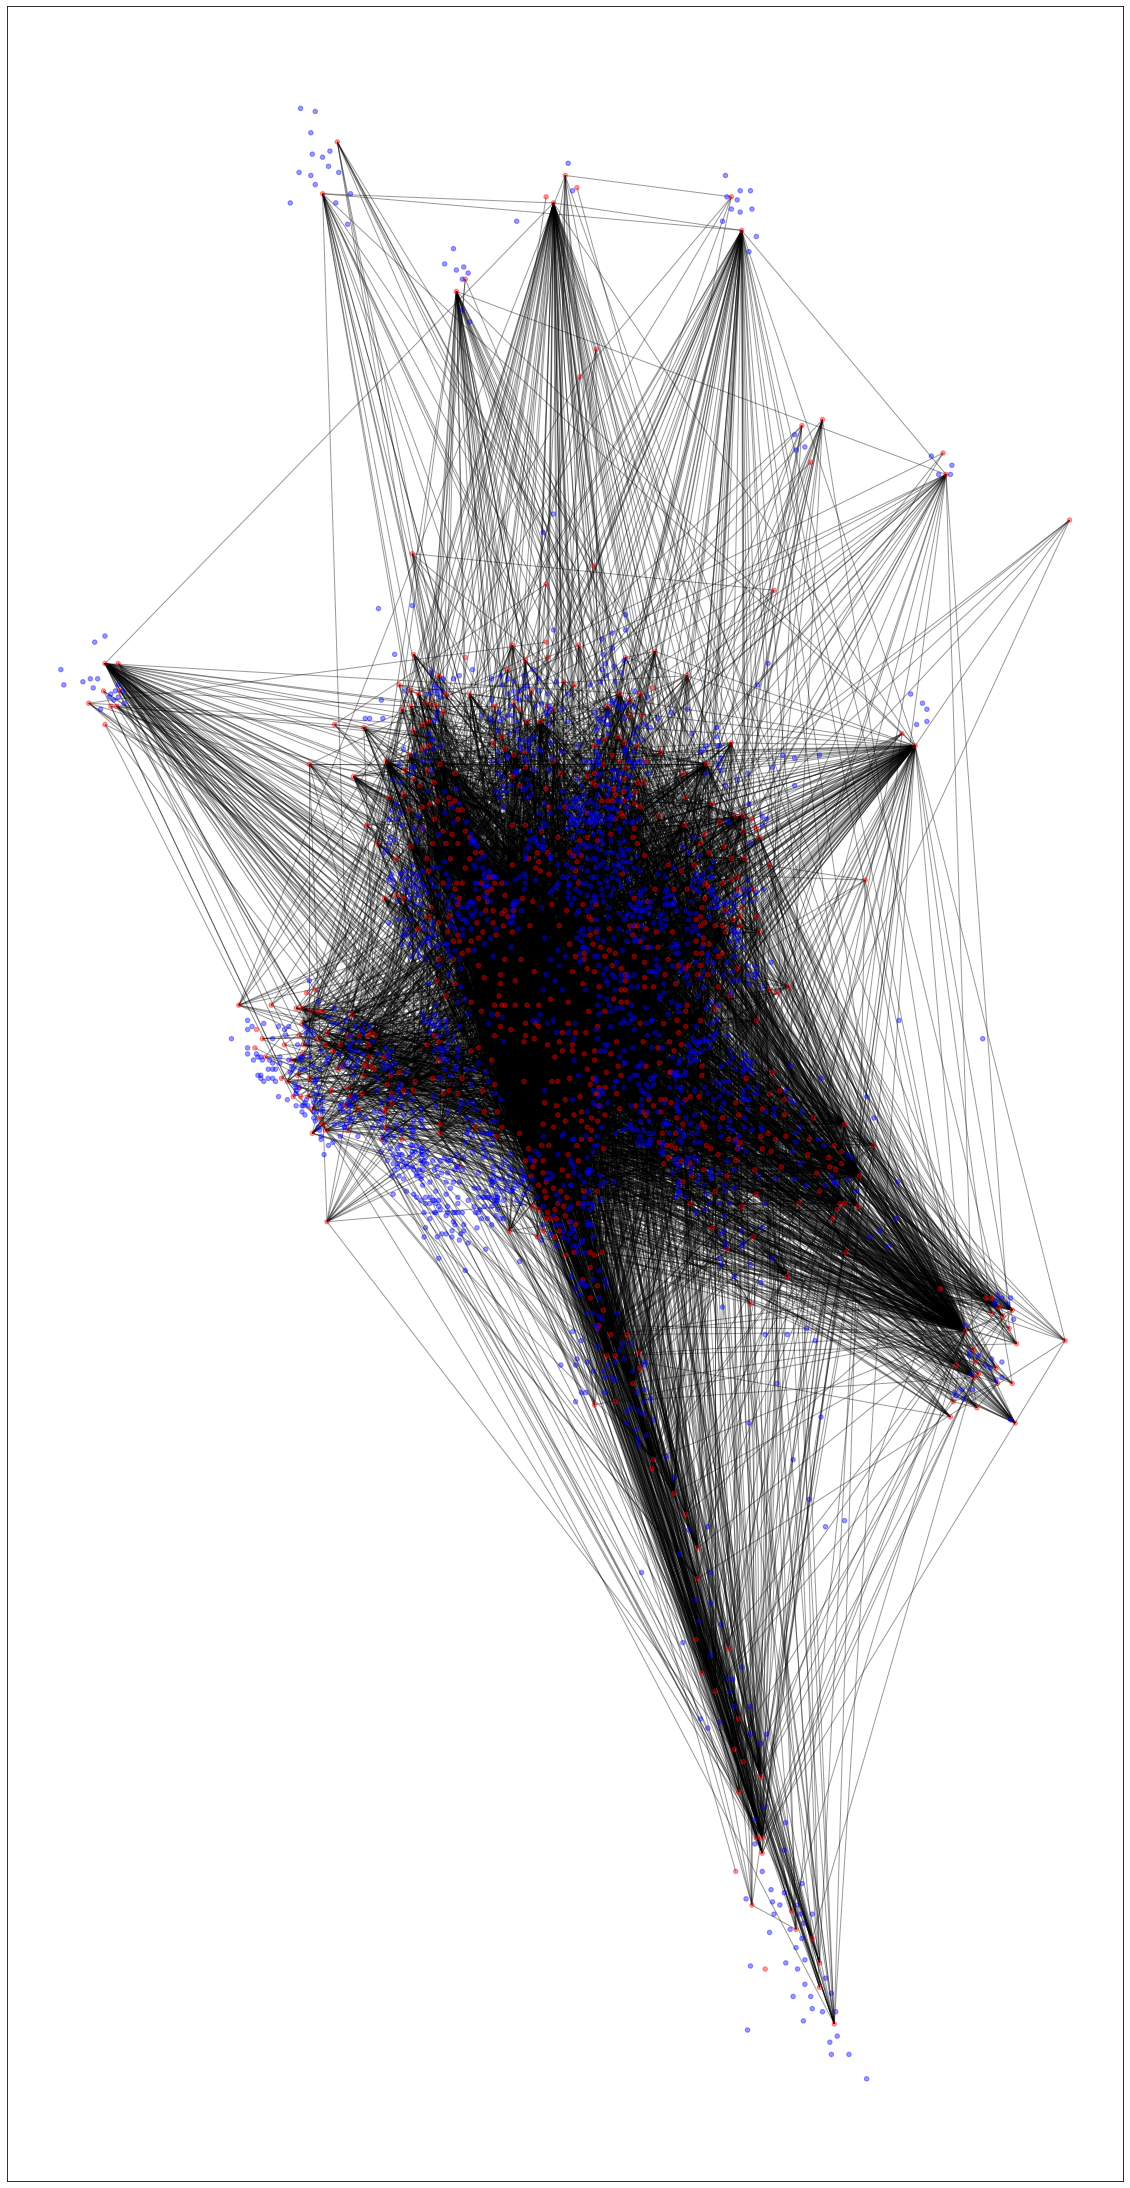

In [35]:
plt.figure(figsize=(20, 40))
color = ["red" if val else "blue" for key, val in nx.get_node_attributes(G, "with_event").items()]
nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

### Now with edge weight according to tuple appearances

In [36]:
network = []
for i in range(len(df_agg.index.levels[0])):
    comb = list(combinations(df_agg.loc[idx[df_agg.index.levels[0][i], :], :].index.get_level_values(1).tolist(), 2))
    if comb:
        network.append(np.insert(np.array(comb), 2,  [df_agg.index.levels[0][i]], axis = 1))

In [37]:
network_df = pd.DataFrame(np.concatenate(network), columns = ["source", "target", "week_id"])

In [38]:
network_df["week_date"] = network_df.week_id.apply(lambda x: df_agg.index.levels[2][np.where(df_agg.index.levels[0] == x)[0][0]]) 

In [40]:
network_df.to_csv("../data/network_same_week_with_dates.csv")

In [41]:
network_agg = network_df.groupby(["source", "target"]).agg(weight=('week_id', "count")).reset_index()
network_agg.sort_values('weight', ascending=False)

source  target  weight
1344   33901   34955      22
4377   34955   35376      18
1403   33901   35376      13
4355   34955   35264      10
4321   34955   35102      10
...      ...     ...     ...
2289   34097   35588       1
2288   34097   35517       1
2287   34097   35416       1
2286   34097   35377       1
6646   36488   36502       1

[6647 rows x 3 columns]

In [42]:
G = nx.from_pandas_edgelist(network_agg, edge_attr= "weight")
G.add_nodes_from(map_df.object_id)
nx.set_node_attributes(G, nodeData)

In [45]:
y = nx.get_node_attributes(G, "y_centroid")
x = nx.get_node_attributes(G, "x_centroid")     
pos = {key:[x[key],y[key]] for key in y.keys()}

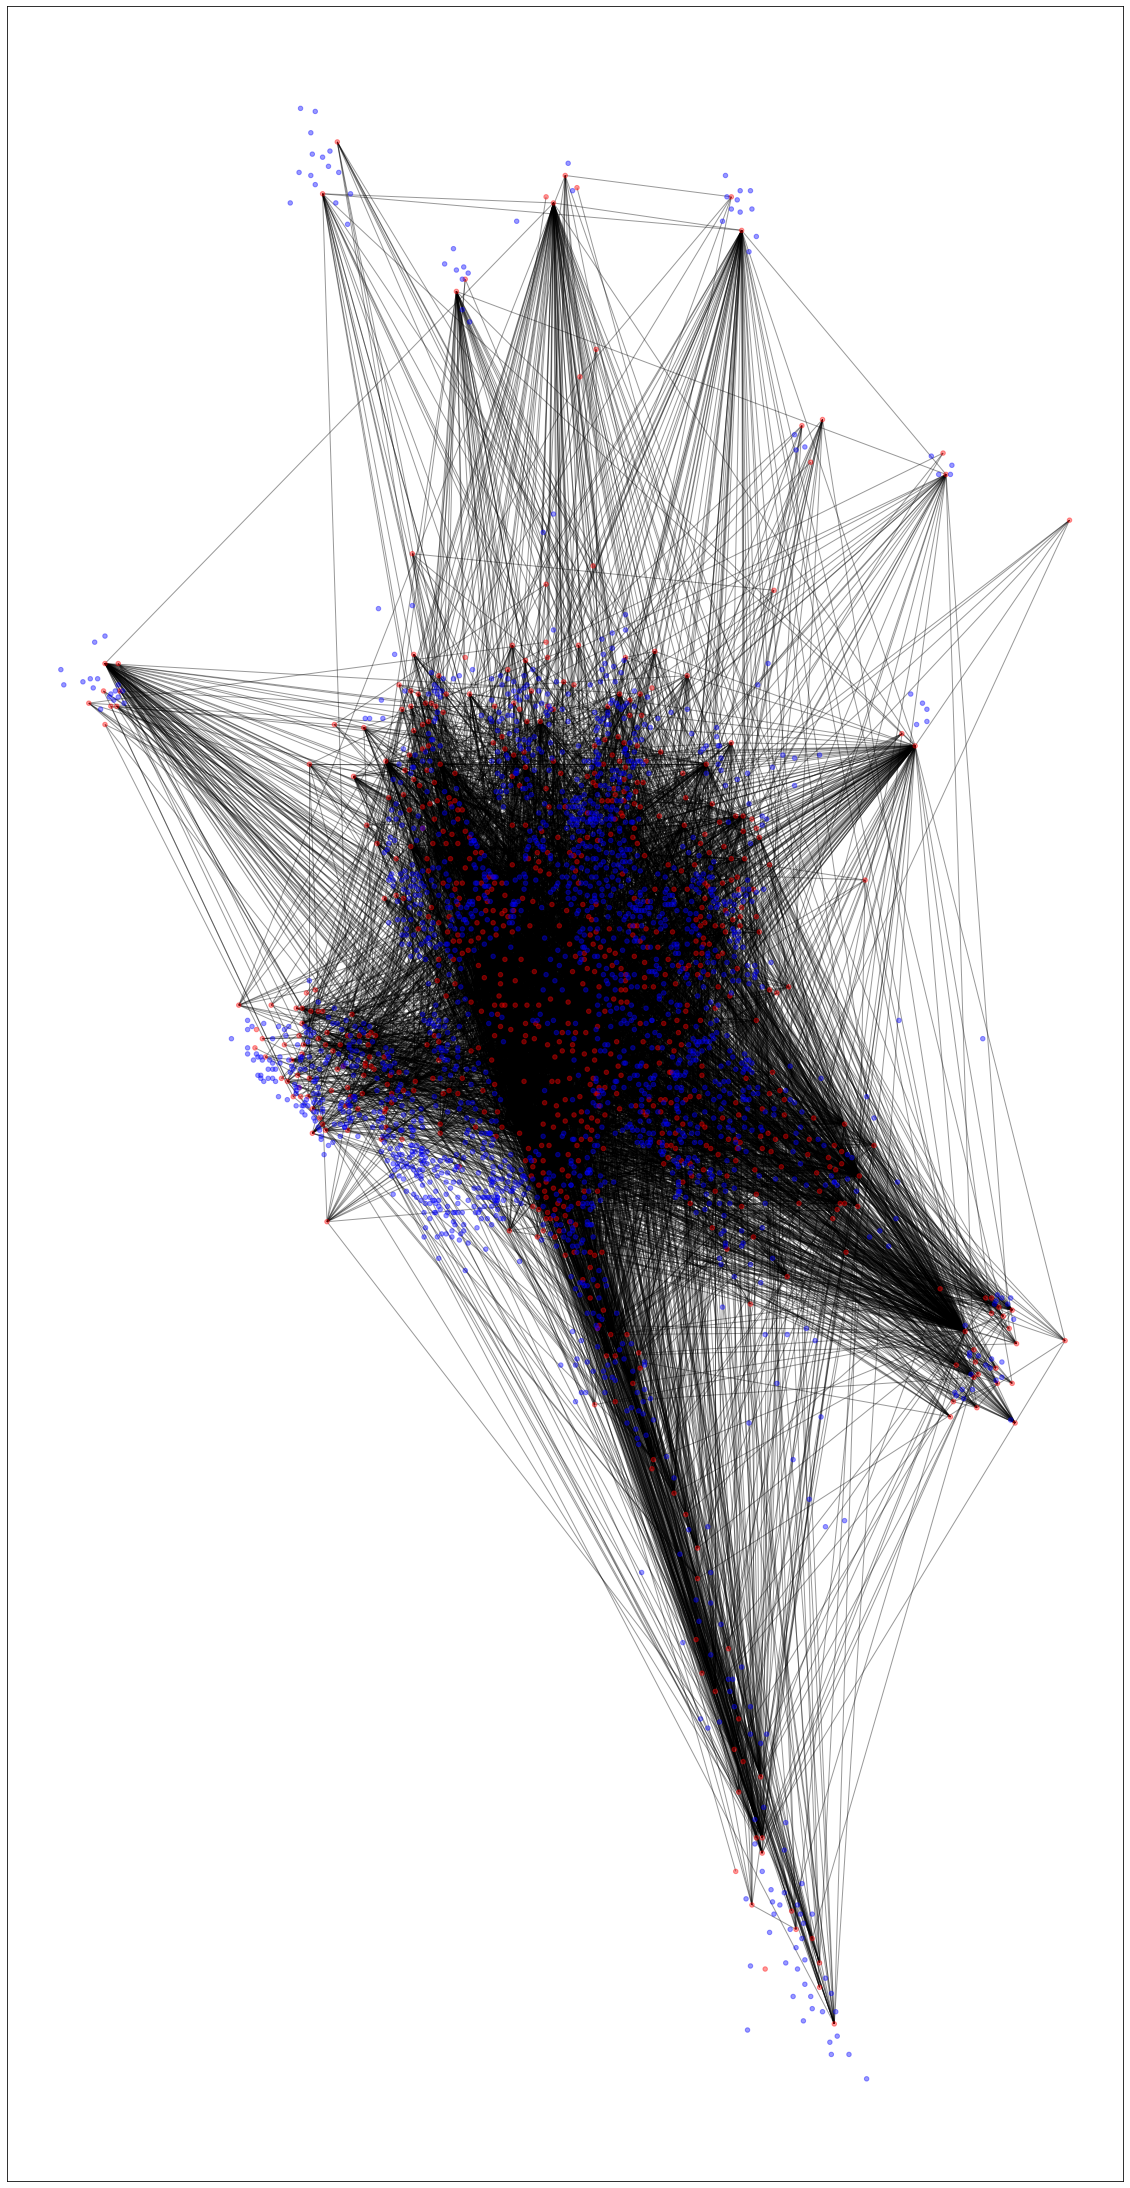

In [46]:
plt.figure(figsize=(20, 40))
color = ["red" if val else "blue" for key, val in nx.get_node_attributes(G, "with_event").items()]
nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

In [47]:
network_agg.to_csv("../data/network_same_week.csv", index=False)

### One week difference network

In [58]:
network = []
for i in range(len(df_agg.index.levels[0])-1):
    in_week1 = df_agg.loc[idx[df_agg.index.levels[0][i], :], :].index.get_level_values(1).tolist()
    in_week2 = df_agg.loc[idx[df_agg.index.levels[0][i+1], :], :].index.get_level_values(1).tolist()
    all_neighborhoods = sorted(in_week1 + in_week2)
    same_week_c =  list(combinations(in_week1, 2)) + list(combinations(in_week2, 2))
    comb = list(combinations(all_neighborhoods, 2))
    for c in same_week_c:
        comb.remove(c)
    if comb:
        network.append(np.insert(np.array(comb), 2,  [df_agg.index.levels[0][i]], axis = 1))

In [59]:
network_df = pd.DataFrame(np.concatenate(network), columns = ["source", "target", "week_id"])

In [60]:
network_df["week_date"] = network_df.week_id.apply(lambda x: df_agg.index.levels[2][np.where(df_agg.index.levels[0] == x)[0][0]]) 

In [63]:
network_df.to_csv("../data/network_one_week_apart_with_dates.csv")

In [62]:
network_agg = network_df.groupby(["source", "target"]).agg(weight=('week_id', "count")).reset_index()
network_agg.sort_values('weight', ascending=False)

source  target  weight
2341    33901   34955      35
7880    34955   34955      28
7995    34955   35376      26
2440    33901   35376      21
7967    34955   35264      19
...       ...     ...     ...
4185    34101   34681       1
4186    34101   34700       1
4188    34101   34717       1
4189    34101   34719       1
11807   36488   36503       1

[11808 rows x 3 columns]

In [64]:
network_agg.to_csv("../data/network_one_week_apart.csv")